In [14]:
import glob
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shelve

x_size, y_size = 85, 15
# data.keys()  # dict_keys(['ligand_len', 'pi', 'd', 'mean', 'sigma', 'vdw_pair', 'hbond_pair'])
pdbs = ['3g2n']
root = 'dock_results/energy_timetest/gaussian_predict'

['0']
17 187
inter_type:HBond, pi:[0.4679 0.0315 0.     0.5005], mean:[0.7885742  0.29541016 0.01611328 0.00439453], y_shape:(5000,)
17 194
inter_type:HBond, pi:[0.4679 0.0315 0.     0.5005], mean:[0.7885742  0.29541016 0.01611328 0.00439453], y_shape:(5000,)
17 200
inter_type:HBond, pi:[0.4679 0.0315 0.     0.5005], mean:[0.7885742  0.29541016 0.01611328 0.00439453], y_shape:(5000,)
17 154
inter_type:OtherPair, pi:[1. 0. 0. 0.], mean:[3.9765625 1.8769531 5.2578125 4.6523438], y_shape:(5000,)
17 219
inter_type:OtherPair, pi:[1. 0. 0. 0.], mean:[3.9257812 1.8994141 5.0546875 4.4257812], y_shape:(5000,)


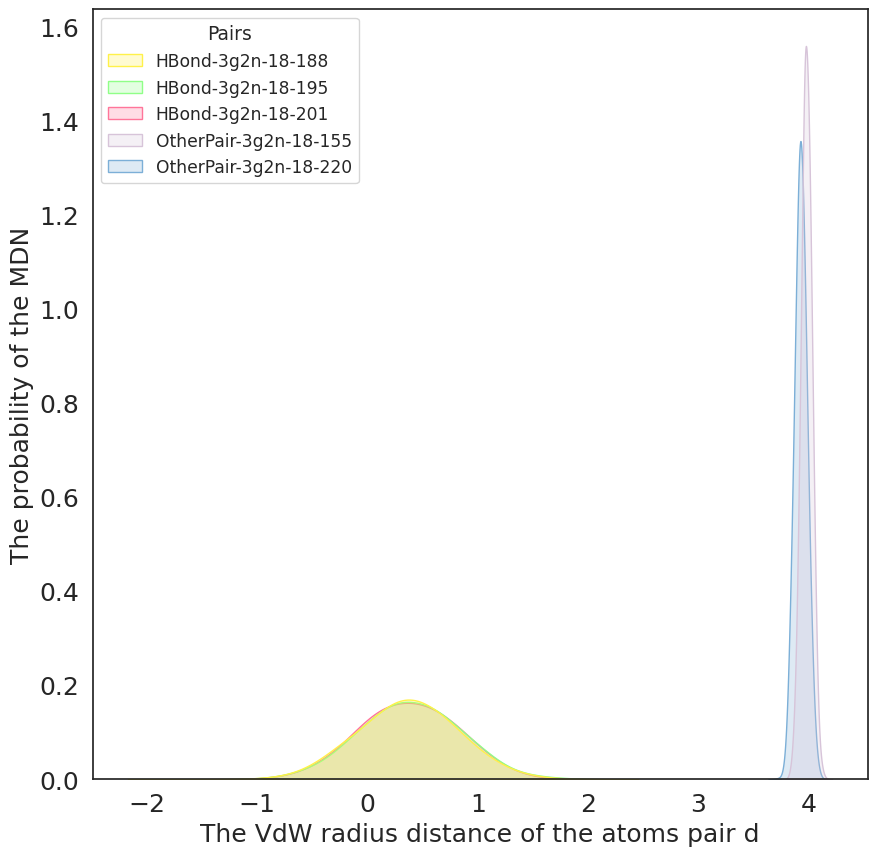

In [16]:
def gaussin(mu, sigma, bins):
    return 1. / (sigma * np.sqrt(2 * np.pi)) * np.exp(- (bins - mu) ** 2 / (2 * sigma ** 2))


def calc_c(inter_type, mean, sigma, pi):
    dists = []
    for i in range(4):
        # i = 3
        dist = np.random.normal(loc=mean[i], scale=sigma[i], size=5000)
        dist = dist * pi[i]
        dists.append(dist[None, :])
    dists = np.concatenate(dists, axis=0)
    y = np.sum(dists, 0)
    print(f'inter_type:{inter_type}, pi:{np.round(pi, 4)}, mean:{mean}, y_shape:{y.shape}')
    return y


# get data
all_data = []
for pdb in pdbs:
    abspath_pkl_normalscore = f'{root}/{pdb}_G.db'
    with shelve.open(abspath_pkl_normalscore) as db:
        print(list(db.keys()))
        data = db['0']
    ln = int(data['ligand_len'][0])
    inter_mask = (slice(0, ln), slice(ln, None))
    d = data['d'][inter_mask]
    hbond_pair = data['hbond_pair'][inter_mask]
    hydro_pair = data['hydro_pair'][inter_mask]
    pi = data['pi'][inter_mask]
    mean = data['mean'][inter_mask]
    sigma = data['sigma'][inter_mask]
    # get gt-hbond
    hbond_i = []
    I, J, _ = np.where(d < -0.1)
    I, J = [17, 17, 17, 17, 17], [187, 194, 200, 154, 219]
    for i, j in zip(I, J):
        print(i, j)
        if i == 17 and j == 187:
            inter_type = 'HBond'
        elif i == 17 and j == 194:
            inter_type = 'HBond'
        elif i == 17 and j == 200:
            inter_type = 'HBond'
        elif i == 17 and j == 154:
            inter_type = 'OtherPair'
        elif i == 17 and j == 219:
            inter_type = 'OtherPair'
        #
        real_j = ln + j
        ij_name = f'{inter_type}-{pdb}-{i + 1}-{j + 1}'
        y = calc_c(inter_type, mean[i, j], sigma[i, j], pi[i, j])
        for y_index, y_i in enumerate(y):
            all_data.append([ij_name, pdb, y_i])

# Draw
fig = plt.figure(figsize=(10, 10))
columns = ['Pairs', 'pdb', 'd']
df = pd.DataFrame(all_data, columns=columns)
sns.set_style("white")
sns.set_context("notebook", font_scale=1.12)
colors = ['#fff149', '#90ff88', '#ff7599', '#D7C4D9', '#7CAFD7']
df = df.sort_values('Pairs') 
g = sns.kdeplot(data=df, x='d', hue='Pairs', fill=True, bw_adjust=2., palette=colors)  #, clip_on=False)

sns.move_legend(g, "upper left")

plt.ylabel('The probability of the MDN', fontsize=18)
plt.xlabel('The VdW radius distance of the atoms pair d', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.show()